In [1]:
import tiled_fuzzer
import codegen
import pindef
import bslib
import chipdb
import fuse_h4x
import gowin_unpack
from wirenames import wirenames
from PIL import Image
import numpy as np
import pickle

def dff(mod, cst, row, col, clk=None):
    "make a dff with optional clock"
    name = tiled_fuzzer.make_name("DFF", "DFF")
    dff = codegen.Primitive("DFF", name)
    dff.portmap['CLK'] = clk if clk else name+"_CLK"
    dff.portmap['D'] = name+"_D"
    dff.portmap['Q'] = name+"_Q"
    mod.wires.update(dff.portmap.values())
    mod.primitives[name] = dff
    cst.cells[name] = f"R{row}C{col}"
    return dff.portmap['CLK']

def ibuf(mod, cst, loc, clk=None):
    "make an ibuf with optional clock"
    name = tiled_fuzzer.make_name("IOB", "IBUF")
    iob = codegen.Primitive("IBUF", name)
    iob.portmap["I"] = name+"_I"
    iob.portmap["O"] = clk if clk else name+"_O"

    mod.wires.update([iob.portmap["O"]])
    mod.inputs.update([iob.portmap["I"]])
    mod.primitives[name] = iob
    cst.ports[name] = loc
    return iob.portmap["O"]

with open(f"{tiled_fuzzer.gowinhome}/IDE/share/device/{tiled_fuzzer.device}/{tiled_fuzzer.device}.fse", 'rb') as f:
    fse = fuse_h4x.readFse(f)
    
with open(f"{tiled_fuzzer.device}.pickle", 'rb') as f:
    db = pickle.load(f)

check 19199191


In [2]:
dff_locs = [(2, 18), (2, 5), (10, 5), (10, 18), (10, 18)]
clock_pins = pindef.get_clock_locs("GW1N-1", "QN48", header=1)
# pins appear to be differential with T/C denoting true/complementary
true_pins = [p[0] for p in clock_pins if "GCLKT" in p[1]]
true_pins

['IOB10A', 'IOR5A', 'IOR7A', 'IOL7A', 'IOB11A']

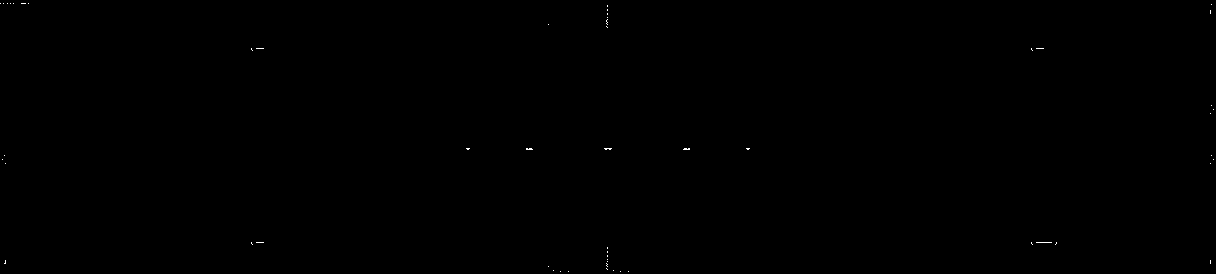

In [3]:
mod = codegen.Module()
cst = codegen.Constraints()

ibufs = [ibuf(mod, cst, p) for p in true_pins]
dffs = [dff(mod, cst, row, col) for row, col in dff_locs]
    

bs, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
bslib.display(None, bs)

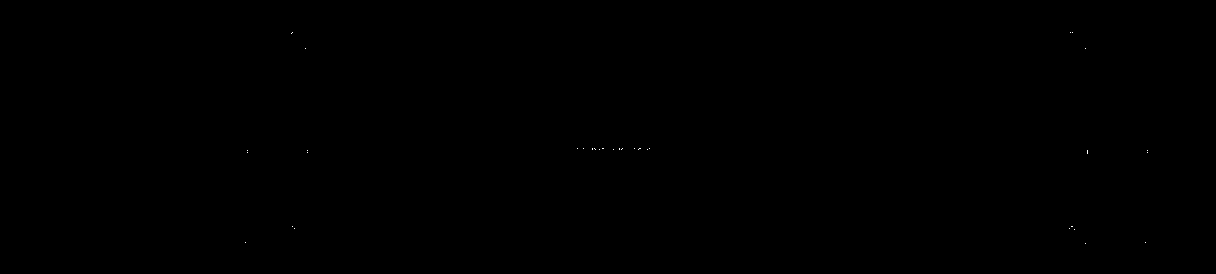

In [4]:
mod.assigns = zip(dffs, ibufs)
bs_clk, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
diff = bs^bs_clk
tiles = fuse_h4x.tile_bitmap(fse, diff)
bslib.display(None, diff)

In [5]:
tiles.keys()

dict_keys([(1, 4, 12), (1, 17, 12), (5, 9, 82), (5, 10, 83), (6, 3, 14), (6, 4, 14), (6, 17, 13), (6, 18, 13), (9, 3, 12), (9, 4, 12), (9, 17, 12), (9, 18, 12)])

dff
(1, 4, 12)


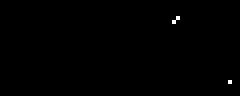

dff
(1, 17, 12)


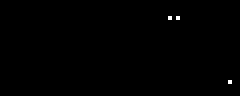

(5, 9, 82)


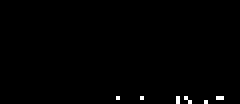

(5, 10, 83)


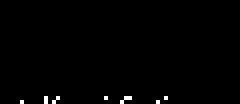

(6, 3, 14)


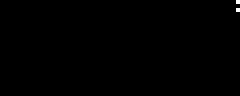

(6, 4, 14)


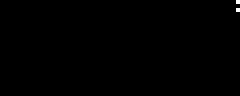

(6, 17, 13)


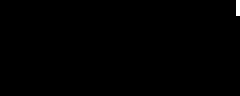

(6, 18, 13)


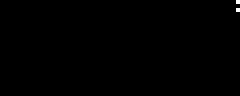

(9, 3, 12)


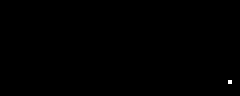

dff
(9, 4, 12)


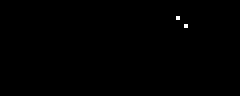

dff
(9, 17, 12)


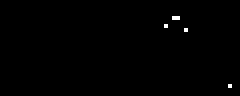

(9, 18, 12)


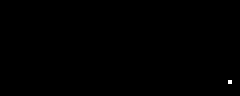

In [6]:
for loc, tile in tiles.items():
    im = bslib.display(None, tile)
    im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
    if (loc[0]+1, loc[1]+1) in dff_locs:
        print('dff')
    print(loc)
    display(im_scaled)

At this point several things are notable.

 * In the DFF that were placed, a few bits in the routing MUXes changed, 99% sure that's just the connection to `GBxx`, which warants confirmation.
 * **No bits in the IOB changed**. This suggests they are by default connected to the clock tree? What if you use the complementary pin?
 * A bunch of bits in the center tile changed, this is probably where the meat of the clock routing happens.
 * In the center row there are a few tiles with 2 bits changed, most likely connecting a horizontal "spine" from the center tile to a vertical "tap".
 * In several tiles there is one bit, most likely connecting the "tap" to a horizontal "branch".
 
This all has to be further explored.

It can be seen that the tiles in which the "spine" is connected to the "taps" are of a distinct type, namely type 13 and 14.

![tile grid](doc/fig/fuse.png)

Meanwhile, looking at the bits within a tile of type 12, it can be seen that the single dots correspond with the bottom right cluster, while the bits of type 13 and 14 are not present. There is an empty column there.

![tile grid](doc/fig/tile.png)

Let's see if tile 13 and 14 indeed have something interesting at these bits.

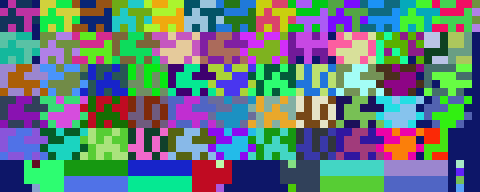

In [7]:
tile = fuse_h4x.render_tile(fse, 14)
im = fuse_h4x.display(None, tile)
im.resize((im.width*8, im.height*8), Image.NEAREST) # THEY DO!

In [8]:
# Lets parse the tile to confirm the MUX
bm = chipdb.tile_bitmap(db, bs_clk)
interesting = {loc[0:2] for loc in tiles.keys()}
for idx, t in bm.items():
    if idx in interesting:
        row, col = idx
        dbtile = db.grid[row][col]
        bels, pips = gowin_unpack.parse_tile_(dbtile, t)
        print(repr(idx) +
              (", DFF0" if 'DFF0' in bels else "") +
              (", DFF1" if 'DFF1' in bels else "") +
              (", CLK0: " + pips['CLK0'] if pips['CLK0'] != "VCC" else "") +
              (", CLK1: " + pips['CLK1'] if pips['CLK1'] != "VCC" else "") +
              (", GBO0: " + pips.get('GBO0') if pips.get('GBO0') else "") +
              (", GBO1: " + pips.get('GBO1') if pips.get('GBO1') else "")
        )

(1, 4), DFF0, DFF1, CLK0: GB10, GBO0: GT00
(1, 17), DFF0, DFF1, CLK0: GB00, GBO0: GT00
(5, 9)
(5, 10)
(6, 3)
(6, 4)
(6, 17)
(6, 18)
(9, 3), GBO0: GT00
(9, 4), DFF0, DFF1, CLK0: GB20
(9, 17), DFF0, DFF1, CLK0: GB30, CLK1: GB40, GBO1: GT10
(9, 18), GBO0: GT00


So this confirms that `CLK0` is indeed connected to `GBxx`, and in fact 4 diffrent `GBxx`.
It also shows that we're already decoding the `GBO0` to `GT00` connection, which I'm 99% sure corresponds to the bottom right bit.
What it all means? Nobody knows. Okay, maybe some god and a few Gowin engineers...

The fact that there is only one `GBO0` to `GT00` connection would suggest it routes all `GBxx` and then selects one locally.
But what's weird is that it seems to route each via a seperate tap, while the DFF are in the same column. Would it then not be more sense to enable one tap for both?
Maybe this is to limit clock skew?

Next step is to dig in the fuse file and confirm the `GBO0` to `GT00` connection and inspect the top right bits in tiles 13 and 14.

In [9]:
spine_tile = tiles[(6, 4, 14)]
#fs = fuse_h4x.scan_fuses(fse, 14, spine_tile)
loc = list(zip(*np.where(spine_tile==1)))
print(loc)
#fuses = fuse_h4x.scan_tables(fse, 14, fs)
#parsed = fuse_h4x.parse_tile(fse, 14, spine_tile)
# stolen from chipdb.py
def fse_pips(fse, ttyp, table):
    pips = {}
    for srcid, destid, *fuses in fse[ttyp]['wire'][table]:
        fuses = {fuse_h4x.fuse_lookup(fse, ttyp, f) for f in chipdb.unpad(fuses)}
        if srcid < 0:
            fuses = set()
            srcid = -srcid
        #if srcid > 1000:
        #    srcid -= 1000 # what does it mean?
        #if destid > 1000:
        #    destid -= 1000 # what does it mean?
        src = wirenames[srcid]
        dest = wirenames[destid]
        pips.setdefault(dest, {})[src] = fuses
    return pips
    
fse_pips(fse, 13, 38)

[(0, 59), (2, 59)]


{'GT00': {'A6': {(0, 59), (2, 59)},
  'B6': {(0, 59), (2, 59)},
  'C6': {(0, 59), (2, 59)},
  'D6': {(0, 59), (2, 59)}},
 'GT10': {'A7': {(1, 59), (3, 59)},
  'B7': {(1, 59), (3, 59)},
  'C7': {(1, 59), (3, 59)},
  'D7': {(1, 59), (3, 59)},
  'N130': {(3, 59)},
  'EW20': {(1, 59), (3, 59)},
  'E130': {(1, 59), (3, 59)},
  'W100': {(1, 59), (3, 59)},
  'W130': {(1, 59)},
  'N200': {(1, 59), (3, 59)},
  'N210': {(1, 59), (3, 59)},
  'N220': {(1, 59), (3, 59)},
  'N230': {(1, 59), (3, 59)}}}

That is... somewhat confusing. But hey, it seems that wire table 38 contains the fuses for the top right bits, which drive `GT00`.
It's worth noting the source wire names might not be accurate, this is after all a completely different wire table.
Normal routing is in table 2.

Note also from `wirenames` that there are just two `GBO0`/`GBO1` and two `GT00`/`GT10`, while there are 8 `GBxx`. (note `O`/`0`).
Does this match with primary/secondary naming in the timing info? Seems plausible.

So okay, I can get into this. *something* drives the vertical `GT00` wires, which drives the horizontal `GBO0` wires, which drives the `GBxx` inputs at th DFF. I think it's time to look at this big and scary center tiles.

In [10]:
print("Wire tables:", list(fse[82]['wire'].keys()), list(fse[83]['wire'].keys())) # table 38 again!
print("Tile 82 destinations:", list(fse_pips(fse, 82, 38).keys()))
print("Tile 14 source:      ", [list(k.keys()) for k in fse_pips(fse, 14, 38).values()])
print("Tile 83 destinations:", list(fse_pips(fse, 83, 38).keys()))
print("Tile 13 source:      ", [list(k.keys()) for k in fse_pips(fse, 13, 38).values()])

Wire tables: [2, 38] [2, 38]
Tile 82 destinations: ['A4', 'B4', 'C4', 'D4', 'A5', 'B5', 'N100', 'SN10', 'SN20', 'N130', 'F0', 'F1', 'F6', 'F2', 'F3', 'F4', 'F5']
Tile 14 source:       [['A4', 'B4', 'C4', 'D4'], ['A5', 'B5', 'C5', 'D5', 'N100', 'SN10', 'SN20', 'N130', 'S100', 'S130', 'E100', 'EW10']]
Tile 83 destinations: ['A6', 'B6', 'C6', 'D6', 'A7', 'B7', 'EW20', 'E130', 'W100', 'W130', 'Q0', 'Q1', 'Q6', 'Q2', 'Q3', 'Q4', 'Q5']
Tile 13 source:       [['A6', 'B6', 'C6', 'D6'], ['A7', 'B7', 'C7', 'D7', 'N130', 'EW20', 'E130', 'W100', 'W130', 'N200', 'N210', 'N220', 'N230']]


This is interesting, it appears that despite the awkward names, most of the routes actually match. The puzzling part is the sources of the center tiles.
Somehow these have to match up with dedicated clock pins and other clock sources.
If the taps and branches indeed switch all 8 global clocks at once, there should be a bunch of different muxes in there.
How is this encoded in the fuse file? No idea. More poking around needed...

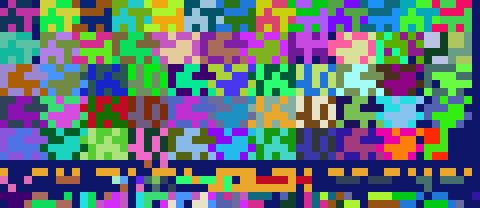

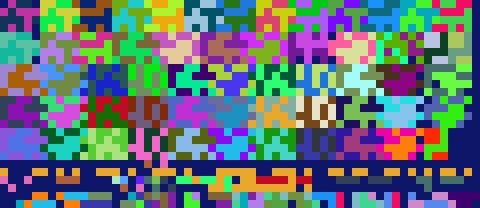

In [11]:
tile = fuse_h4x.render_tile(fse, 83)
im = fuse_h4x.display(None, tile)
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

im = bslib.display(None, tiles[(5, 10, 83)][-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

tile = fuse_h4x.render_tile(fse, 82)
im = fuse_h4x.display(None, tile)
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

im = bslib.display(None, tiles[(5, 9, 82)][-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

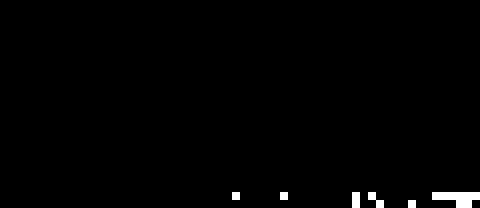

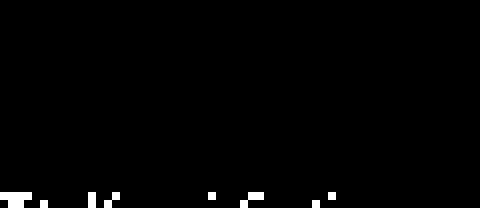

In [12]:
# just to verify that the tile itself rather than the diff doesn't have more interesting stuff.
# it does not. A few const bits that are always there.
tiles_clk = fuse_h4x.tile_bitmap(fse, bs_clk)
im = bslib.display(None, tiles_clk[(5, 9, 82)])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))
im = bslib.display(None, tiles_clk[(5, 10, 83)])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

In [13]:
p = fse_pips(fse, 14, 2)
p['GBO0'], p['GBO1'] # there is only one option here

({'GT00': {(20, 57)}}, {'GT10': {(21, 57)}})

In [14]:
# lets do some dumb fuzzing!
from multiprocessing.dummy import Pool

mod = codegen.Module()
cst = codegen.Constraints()
ibuf(mod, cst, true_pins[2], clk="myclk")
base_bs, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

modules = []
constrs = []
for i in range(2, 20):
    mod = codegen.Module()
    cst = codegen.Constraints()

    ibuf(mod, cst, true_pins[0], clk="myclk")
    dff(mod, cst, 8, i, clk="myclk")
    
    modules.append(mod)
    constrs.append(cst)


p = Pool()
pnr_res = p.map(lambda param: tiled_fuzzer.run_pnr(*param, {}), zip(modules, constrs))

In [15]:
for sweep_bs, *rest in pnr_res:
    sweep_tiles = fuse_h4x.tile_bitmap(fse, sweep_bs^base_bs)
    
    print("#"*80)
    for loc, tile in sweep_tiles.items():
        row, col, ttyp = loc
        dbtile = db.grid[row][col]
        bels, pips = gowin_unpack.parse_tile_(dbtile, tile)
        if ttyp == 12:
            print("branch", col)
            pass
        elif ttyp in {13, 14}:
            print("tap", col)
        elif ttyp in {82, 83}:
            im = bslib.display(None, tile[-2:,:])
            im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
            display(im_scaled)

################################################################################


tap 1
branch 1
################################################################################


tap 1
branch 1
branch 2
################################################################################


tap 1
branch 1
branch 3
################################################################################


tap 5
branch 4
branch 5
################################################################################


tap 5
branch 5
################################################################################


tap 5
branch 5
branch 6
################################################################################


tap 5
branch 5
branch 7
################################################################################


tap 5
branch 5
branch 8
################################################################################


tap 5
branch 5
branch 9
################################################################################


tap 13
branch 10
branch 13
################################################################################


tap 13
branch 11
branch 13
################################################################################


tap 13
branch 12
branch 13
################################################################################


tap 13
branch 13
################################################################################


tap 13
branch 13
branch 14
################################################################################


tap 13
branch 13
branch 15
################################################################################


tap 17
branch 16
branch 17
################################################################################


tap 17
branch 17
################################################################################


tap 17
branch 17
branch 18


In [16]:
# that's... not what I expected. I changed a few things but it seems pretty consistent.
# lemme try changing between clock inputs to see if ANYTHING changes...

mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]
flop = dff(mod, cst, 2, 2)

bs_base, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

clk_bss = []
for clk in clks:
    mod.assigns = [(flop, clk)]
    bs_clkn, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
    clk_bss.append(bs_clkn)

In [17]:
for mybs in clk_bss:
    clk_tiles = fuse_h4x.tile_bitmap(fse, mybs^bs_base)
    im = bslib.display(None, clk_tiles[(5, 9, 82)][-2:,:])
    display(im.resize((im.width*8, im.height*8), Image.NEAREST))
    
tile = fuse_h4x.render_tile(fse, 82)
im = fuse_h4x.display(None, tile[-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

Fascinating... so if I sweep a DFF along all the colums, it basically takes the clock from taps 1, 5, 13, 17. The only change in the center mux is between left/right.
When instead I sweep the clock pin used, it only changes a few bits in the center mux. So I'm kinda assuming that particular mux is hardwired to these two taps on each side, and other muxes drive other taps along the spine.

Since I don't have a trivial way to make it use any other mux voluntarily, fuzzing this will be a big PITA. It probably pays off to look at the vendor data more deeply.

I wonder what happens if I fill a whole row with DFF. Many rows? The whole FPGA? What if I fill a whole row with each different clock pin, and then cycle the pins around? Time to find out.

In [18]:
mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]

for i in range(2, 7):
    for j in range(2, 20):
        if i < 6:
            flop = dff(mod, cst, i, j)
        else:
            flop = dff(mod, cst, 2+i, j)

bs_base, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]

for i in range(2, 7):
    for j in range(2, 20):
        if i < 6:
            flop = dff(mod, cst, i, j)
        else:
            flop = dff(mod, cst, 2+i, j)
        mod.assigns.append((flop, clks[0]))

bs_oneclk, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]

for i, clk in enumerate(clks):
    for j in range(2, 20):
        if i < 4:
            flop = dff(mod, cst, 2+i, j)
        else:
            flop = dff(mod, cst, 4+i, j)
        mod.assigns.append((flop, clk))

bs_allclks, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

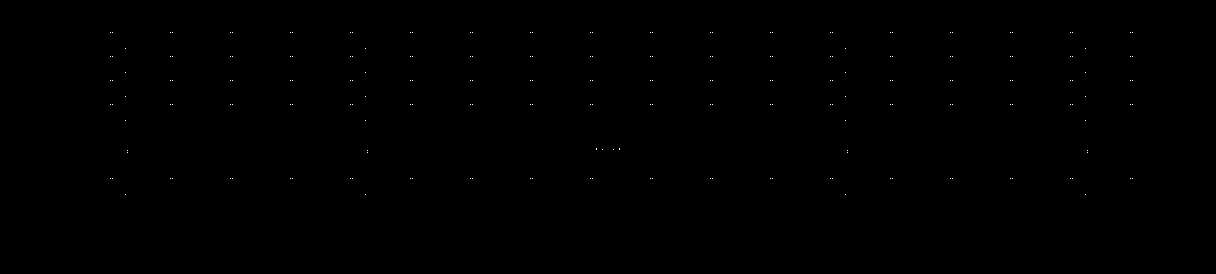

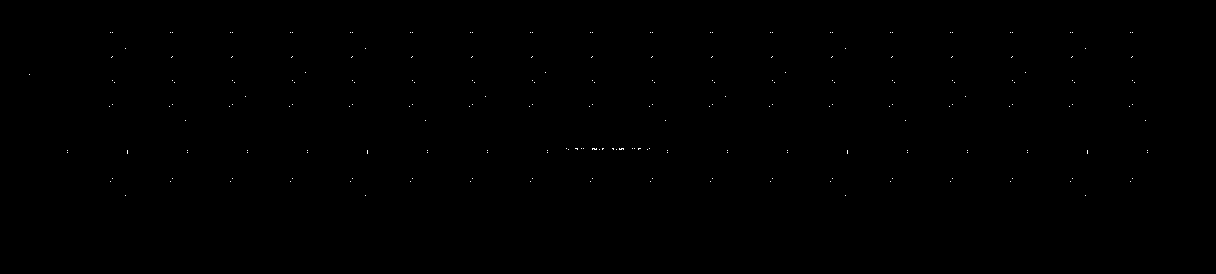

In [19]:
display(bslib.display(None, bs_oneclk^bs_base))
display(bslib.display(None, bs_allclks^bs_base))

At this point I kinda understand the single-clock case well enough. The two inner muxes select a clock source, and route it to columns 1, 5, 13, 17. From there two fuses enable the tap, and at each row the single fuse enables the branch for the cells around it. A bit up we saw that columns 1-3 are controlled from tap 1, 4-9 from tap 5, 10-15 from tap 13, and 16-18 from tap 17.

For the case of multiple clocks, we can see that all GT00 (primary?) spines are enabled, and the 5th pin is connected to GT10. This lines up with the one-clock case. Would it be the case that GB00-GB30 are GT00 and GB40-GB70 are GT10? It seems like that so far. What if I do 4 clocks, and then change one pin at a time and see what changes?

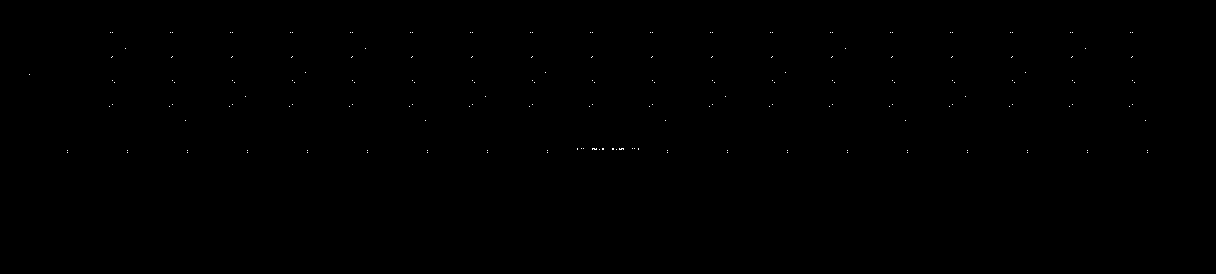

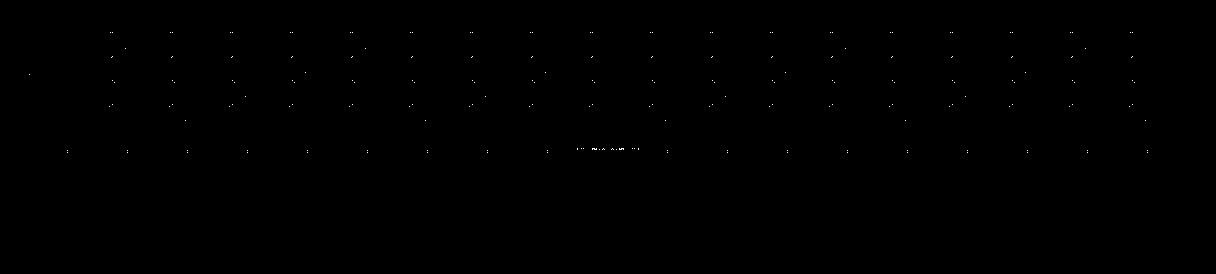

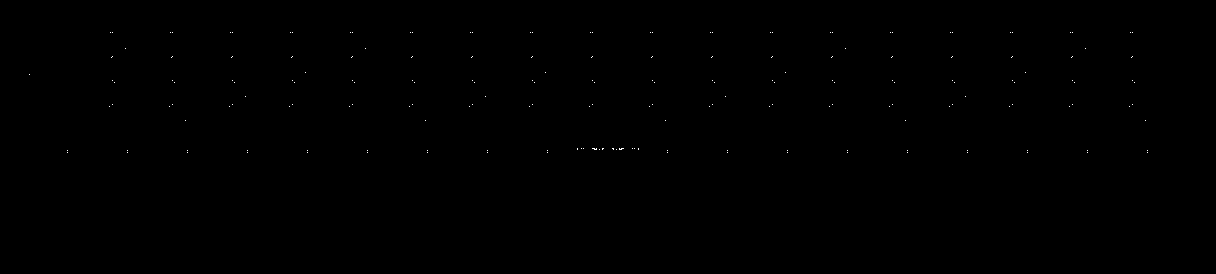

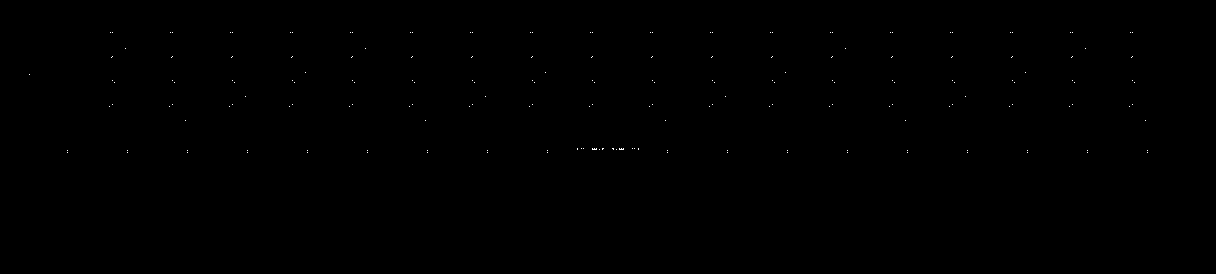

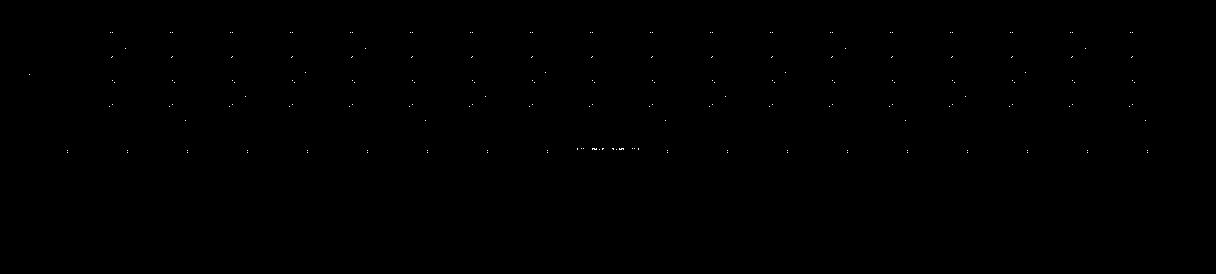

In [20]:
mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]

for i in range(2, 6):
    for j in range(2, 20):
        flop = dff(mod, cst, i, j)

bs_base, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

clk_sweep_bs = []
for k in range(5):
    mod = codegen.Module()
    cst = codegen.Constraints()

    clks = [ibuf(mod, cst, p) for p in true_pins]

    for i, clk in enumerate(clks[:-1]):
        for j in range(2, 20):
            flop = dff(mod, cst, 2+i, j)
            if i == k:
                mod.assigns.append((flop, clks[-1]))
            else:
                mod.assigns.append((flop, clk))

    bs_tmp, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
    clk_sweep_bs.append(bs_tmp)

for mybs in clk_sweep_bs:
    display(bslib.display(None, mybs^bs_base))

In [21]:
tile = fuse_h4x.render_tile(fse, 82)
im = fuse_h4x.display(None, tile[-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

for mybs in clk_sweep_bs[:-1]:
    clk_tiles = fuse_h4x.tile_bitmap(fse, mybs^clk_sweep_bs[-1])
    ctile = clk_tiles[(5, 9, 82)].astype('uint8')
    im = fuse_h4x.display(None, (tile*ctile)[-2:,:])
    display(im.resize((im.width*8, im.height*8), Image.NEAREST))

So hey, when you swap a clock it keeps the routing the same, but just changes one mux. This makes sense. Now what I want to know is which columns correspond to which mux. Let's take it row by row, and see if we can tell that way.

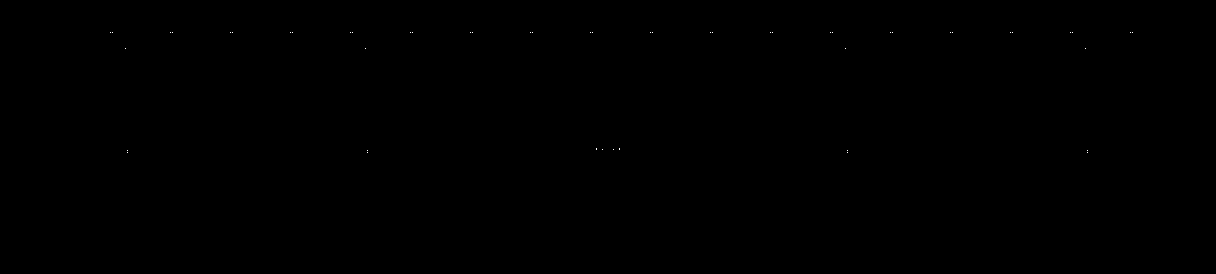

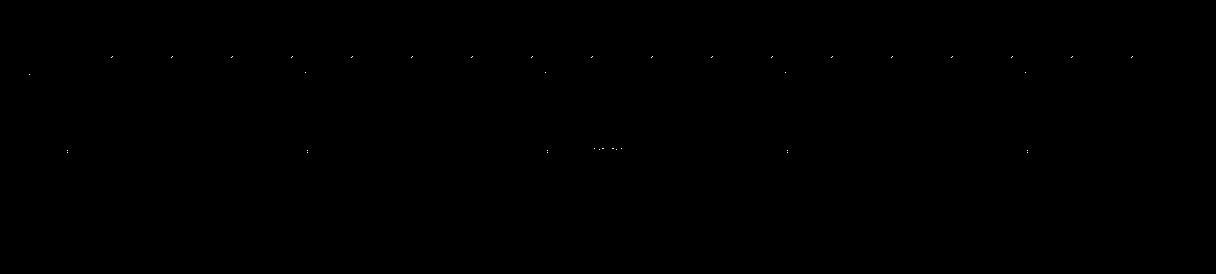

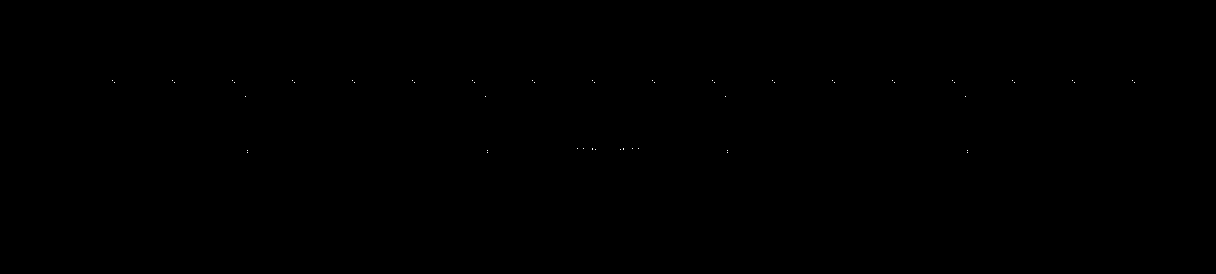

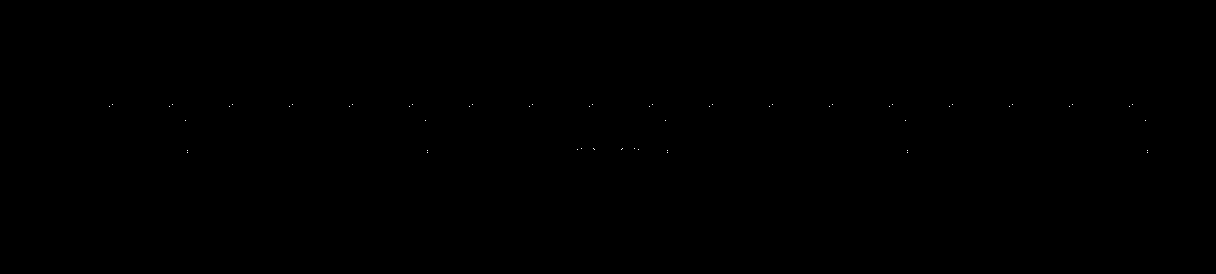

In [22]:
mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]

for i in range(2, 6):
    for j in range(2, 20):
        flop = dff(mod, cst, i, j)

bs_base, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

clk_march_bs = []
for k in range(4):
    mod = codegen.Module()
    cst = codegen.Constraints()

    clks = [ibuf(mod, cst, p) for p in true_pins]

    for i, clk in enumerate(clks[:-1]):
        for j in range(2, 20):
            flop = dff(mod, cst, 2+i, j)
            if i <= k:
                mod.assigns.append((flop, clk))

    bs_tmp, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})
    clk_march_bs.append(bs_tmp)

base_tmp = bs_base
for mybs in clk_march_bs:
    display(bslib.display(None, mybs^base_tmp))
    base_tmp = mybs

Alriiiiight!! So As before, we got 1, 5, 13, 17 for the first mux. Then the second mux goes 0, 4, 8, 12, 16. Third 3, 7, 11, 15. And fourth 2, 6, 10, 14, 18.

In [23]:
tile = fuse_h4x.render_tile(fse, 82)
im = fuse_h4x.display(None, tile[-2:,:])
display(im.resize((im.width*8, im.height*8), Image.NEAREST))

base_tmp = bs_base
for mybs in clk_march_bs:
    clk_tiles = fuse_h4x.tile_bitmap(fse, mybs^base_tmp)
    ctile = clk_tiles[(5, 9, 82)].astype('uint8')
    im = fuse_h4x.display(None, (tile*ctile)[-2:,:])
    display(im.resize((im.width*8, im.height*8), Image.NEAREST))
    base_tmp = mybs

In [24]:
mt = fuse_h4x.tile_bitmap(fse, clk_march_bs[-1])
interesting = {(1,1): mt[(1, 1, 12)], (2,1): mt[(2, 1, 12)], (3,1): mt[(3, 1, 12)], (4, 1): mt[(4, 1, 12)]}
for idx, t in interesting.items():
    row, col = idx
    dbtile = db.grid[row][col]
    bels, pips = gowin_unpack.parse_tile_(dbtile, t)
    print(idx, pips['CLK0'])

(1, 1) GB00
(2, 1) GB10
(3, 1) GB20
(4, 1) GB30


This seems to confirm my earlier findings. I think the main thing that needs to be done is find the boundaries of each branch. Maybe I can use one full row, and then do a sweep on the next row/clock to see which tap it connects to. I just hope it doesn't randomly alternate which clock goes where.

Then I need to find some more clock sources to do it all again for the secondary clocks. And then I think it may be time to write the real fuzzer???

In [25]:
mod = codegen.Module()
cst = codegen.Constraints()

clks = [ibuf(mod, cst, p) for p in true_pins]

for i in range(2, 6):
    for j in range(2, 20):
        flop = dff(mod, cst, i, j)

bs_base, hdr, ftr, posp, config = tiled_fuzzer.run_pnr(mod, cst, {})

modules = []
constrs = []
for k in range(4):
    for col in range(2, 20):
        mod = codegen.Module()
        cst = codegen.Constraints()

        clks = [ibuf(mod, cst, p) for p in true_pins]

        for i, clk in enumerate(clks[:-1]):
            for j in range(2, 20):
                flop = dff(mod, cst, 2+i, j)
                if i < k:
                    mod.assigns.append((flop, clk))
                elif i == k and j == col:
                    mod.assigns.append((flop, clk))

        modules.append(mod)
        constrs.append(cst)

p = Pool()
pnr_res = p.map(lambda param: tiled_fuzzer.run_pnr(*param, {}), zip(modules, constrs))

In [26]:
clks = {}
complete_taps = set()
for idx, (sweep_bs, *rest) in enumerate(pnr_res):
    #display(bslib.display(None, sweep_bs^bs_base))
    sweep_tiles = fuse_h4x.tile_bitmap(fse, sweep_bs^bs_base)
    
    dff = set()
    tap = None
    gclk = idx//18
    if idx and idx%18==0:
        complete_taps.update(clks[gclk-1].keys())
    #print("#"*80)
    for loc, tile in sweep_tiles.items():
        row, col, ttyp = loc
        #print(row, idx//18)
        #print(ttyp)
        if row <= gclk: continue
        if ttyp == 12:
            #print("branch", col)
            dff.add(col)
        elif ttyp in {64, 13, 14}:
            #print("tap", col)
            if col not in complete_taps:
                tap = col
    clks.setdefault(gclk, {}).setdefault(tap, set()).update(dff)
    #print(complete_taps, clks)

clks

{0: {1: {1, 2, 3},
  5: {4, 5, 6, 7, 8, 9},
  13: {10, 11, 12, 13, 14, 15},
  17: {16, 17, 18}},
 1: {0: {1, 2},
  4: {3, 4, 5, 6},
  8: {7, 8, 9},
  12: {10, 11, 12, 13, 14},
  16: {15, 16, 17, 18}},
 2: {3: {1, 2, 3, 4, 5},
  7: {6, 7, 8, 9},
  11: {10, 11, 12, 13},
  15: {14, 15, 16, 17, 18}},
 3: {2: {1, 2, 3, 4},
  6: {5, 6, 7, 8, 9},
  10: {10, 11, 12},
  14: {13, 14, 15, 16},
  18: {17, 18}}}

I think this a pretty good place to switch to the real fuzzer. At this point it's clear which center muxes drive which spines/taps/branches, and how it all connects. The only thing that's missing is the secondary clocks, which is just more of the same. I just need to find some more clock inputs, maybe the PLL outputs?

Here is a diagram of my current understanding. The muxes in the center connect a clock pin to the left or right spines. Each specific spine has 2-3 taps per side, which route it up and down. At each row this tap can then be connected to a branch that spans several colums. The different colours in this diagram represent GB00-GB40 at the slice level.
![clocks](doc/fig/clocks.png)